In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
from tensorflow.keras.utils import image_dataset_from_directory

img_size = (256, 256)
train_ds = image_dataset_from_directory(
    "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train",image_size=img_size)
val_ds = image_dataset_from_directory(
    "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid",image_size=img_size)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [22]:
from tensorflow.keras.metrics import Recall, Precision

metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    'accuracy']

In [23]:
from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import BinaryCrossentropy

model = models.Sequential()

model.add(layers.Rescaling(1/255, input_shape=(img_size[0], img_size[1] ,3)))
model.add(layers.Conv2D(100, kernel_size = (3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(50, kernel_size = (2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(25, kernel_size = (2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.2)) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=metrics)

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 100)     2800      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 100)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 50)      20050     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 50)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 25)       

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(patience = 50, restore_best_weights = True, monitor = 'val_loss')

mcp = ModelCheckpoint("{}.h5".format('simple_model'),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history = model.fit(train_ds,
          validation_data = val_ds,
          batch_size = 32,
          epochs = 3,
          callbacks = [es, mcp])

Epoch 1/3
3125/3125 [==============================] - 343s 108ms/step - loss: 0.5291 - recall: 0.7356 - precision: 0.7235 - accuracy: 0.7272 - val_loss: 0.4017 - val_recall: 0.8450 - val_precision: 0.8061 - val_accuracy: 0.8209
Epoch 2/3
3125/3125 [==============================] - 331s 106ms/step - loss: 0.3533 - recall: 0.8558 - precision: 0.8444 - accuracy: 0.8491 - val_loss: 0.2975 - val_recall: 0.8548 - val_precision: 0.8834 - val_accuracy: 0.8710
Epoch 3/3
3125/3125 [==============================] - 332s 106ms/step - loss: 0.2597 - recall: 0.9041 - precision: 0.8898 - accuracy: 0.8960 - val_loss: 0.2770 - val_recall: 0.9028 - val_precision: 0.8780 - val_accuracy: 0.8887


In [26]:
import matplotlib.pyplot as plt
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()


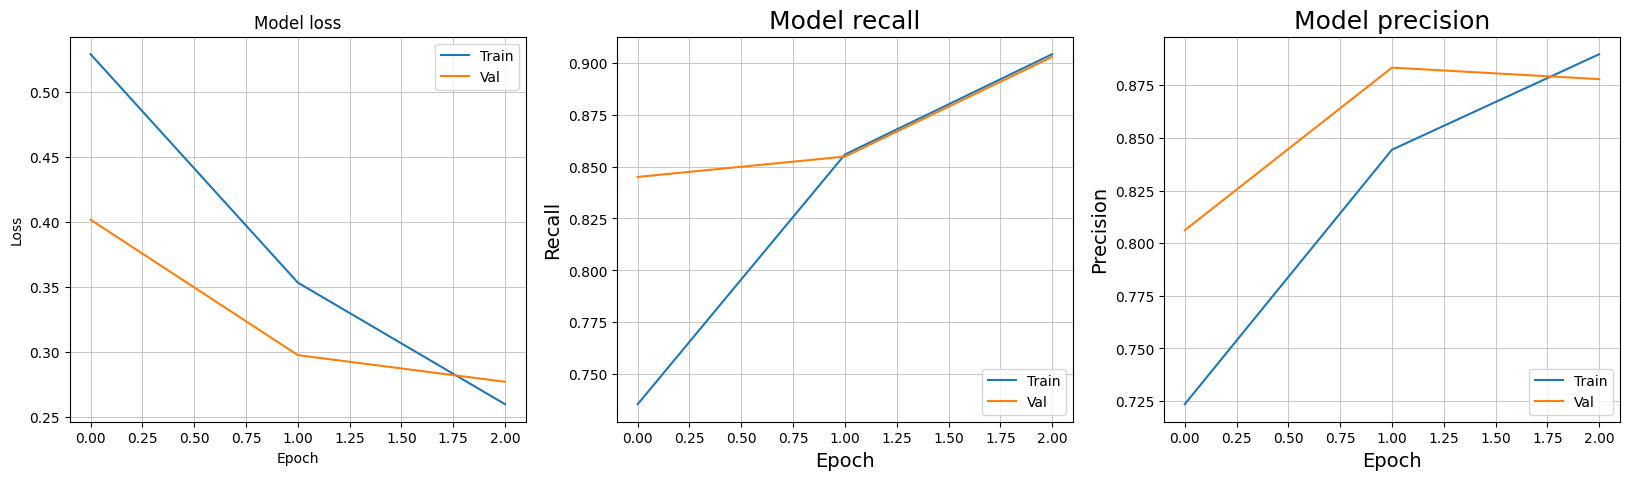

In [27]:
plot_loss_precision_recall_curve(history)

In [54]:
#if validation set has to be used to create validation matrix
y_val = []

# Iterate through the val_ds dataset and extract labels
for images, labels in val_ds:
    y_val.extend(labels.numpy().astype(int))

# Convert the list to a NumPy array
y_val = np.array(y_val)

In [62]:
#in case test data set exists (test_ds)
test_ds = image_dataset_from_directory("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test",image_size=img_size)

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

unbatched_test_ds = test_ds.unbatch()
y_true = np.array(list(unbatched_test_ds.map(lambda x, y: y)))

Found 20000 files belonging to 2 classes.
625/625 [==============================] - 29s 46ms/step


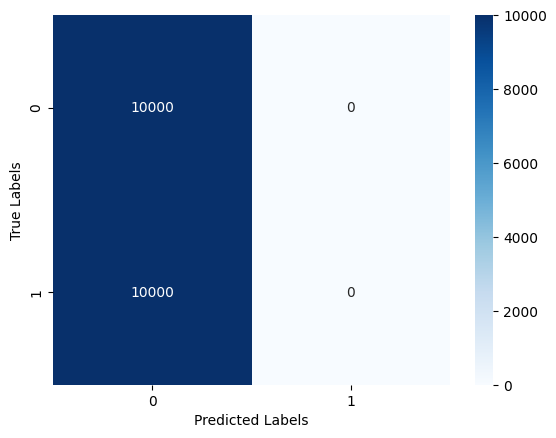

In [63]:
#Create Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true, predicted_labels)

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

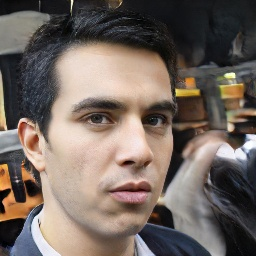

In [58]:
#Show one image (change image name)
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


#img_size = (600,600)
img_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/00V8VPXL3V.jpg"

last_conv_layer_name = "conv2d_14"
display(Image(img_path))

1/1 [==============================] - 0s 22ms/step


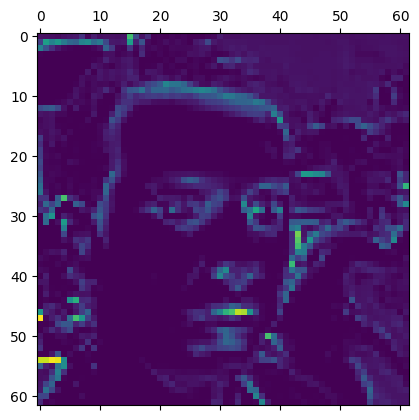

In [59]:
#Plot heat map of weights
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



img_array = get_img_array(img_path, size=img_size)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
